In [1]:
# import modules, define some functions for loading, saving and processing a gene-barcode matrix
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import h5py
from scipy import stats
import csv
from scipy import ndimage
from scipy import spatial
import seaborn as sns

np.random.seed(0)

FeatureBCMatrix = collections.namedtuple('FeatureBCMatrix', ['feature_ids', 'feature_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename):
    with h5py.File(filename) as f:
        if u'version' in f.attrs:
            if f.attrs['version'] > 2:
                raise ValueError('Matrix HDF5 file format version (%d) is an newer version that is not supported by this function.' % version)
        else:
            raise ValueError('Matrix HDF5 file format version (%d) is an older version that is not supported by this function.' % version)
        
        feature_ids = [x.decode('ascii', 'ignore') for x in f['matrix']['features']['id']]
        feature_names = np.asarray([x.decode('ascii', 'ignore') for x in f['matrix']['features']['name']])    
        barcodes = np.asarray(list(f['matrix']['barcodes'][:]))
        matrix = sp_sparse.csc_matrix((f['matrix']['data'], f['matrix']['indices'], f['matrix']['indptr']), shape=f['matrix']['shape'])
        return FeatureBCMatrix(feature_ids, feature_names, barcodes, matrix)

def get_expression(fbm, gene_name):
    try:
        gene_index = fbm.feature_names.index(gene_name)
    except ValueError:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return fbm.matrix[gene_index, :].toarray().squeeze()
        
def subsample_matrix(gbm, barcode_indices):
    return FeatureBCMatrix(gbm.feature_ids, gbm.feature_names, gbm.barcodes[barcode_indices], gbm.matrix[:, barcode_indices])

/home/dlab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


10 clusters


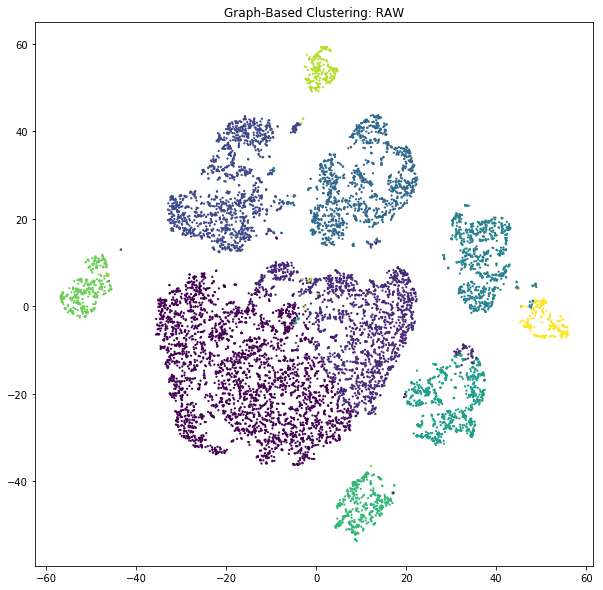

In [2]:
folder='FLARE2'
project='Thy1L_Aggr'
dataset='Thy1L_Aggr'
params=''
savefolder='/media/storage/ckk/genomics/scripts/figs/NAc/'

analysis_dir = '/media/storage/ckk/genomics/data/'+folder+'/reanalysis/'+project+'/'+dataset+'_QC'+params+'/outs/analysis/'
tsne_file = analysis_dir+"tsne/2_components/projection.csv"

clusters_file = analysis_dir+'clustering/kmeans_10_clusters/clusters.csv'
diffexp_file = analysis_dir+'diffexp/kmeans_10_clusters/differential_expression.csv'
print('10 clusters')

# load TSNE and graph clustering
tsne = pd.read_csv(tsne_file)
clusters = pd.read_csv(clusters_file)

# plot all clusters in TSNE space
plt.figure(figsize=(10, 10))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=clusters['Cluster'], linewidths=0, s=5)
plt.title('Graph-Based Clustering: RAW')
#plt.savefig(savefolder+project+'_tsneclust.eps', format='eps', dpi=1000)

del_barcodes=np.array([])

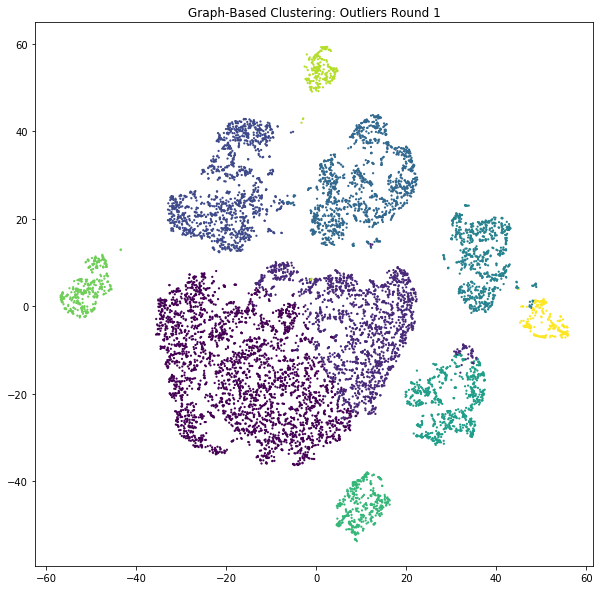

In [3]:
# Round 1: remove outliers (scale based on size of cluster)
num_clusters=max(clusters['Cluster'])
comx=np.array([])
comy=np.array([])
del_outliers_round1=np.array([])
del_barcodes_round1=np.array([])
for x in range(0,num_clusters):
    curr_clust=np.where(clusters['Cluster']==x+1)[0]
    
    # scale to min and max
    xmin=np.min(tsne['TSNE-1'].iloc[curr_clust])
    xmax=np.max(tsne['TSNE-1'].iloc[curr_clust])
    ymin=np.min(tsne['TSNE-2'].iloc[curr_clust])
    ymax=np.max(tsne['TSNE-2'].iloc[curr_clust])

    curr_x=(tsne['TSNE-1'].iloc[curr_clust]-xmin)/(xmax-xmin)
    curr_y=(tsne['TSNE-2'].iloc[curr_clust]-ymin)/(ymax-ymin)
    
    comx=np.append(comx,np.median(curr_x))
    comy=np.append(comy,np.median(curr_y))
    
    dist=np.array([])
    for y in range(0,len(curr_clust)):
        dist=np.append(dist,spatial.distance.euclidean([comx[x],comy[x]],[curr_x[curr_clust[y]],curr_y[curr_clust[y]]]))
    outliers=np.where(dist>0.5)[0]
    del_outliers_round1=np.append(del_outliers_round1,np.asarray(curr_clust[outliers])).astype(int)
    del_barcodes_round1=np.append(del_barcodes_round1,clusters['Barcode'].iloc[curr_clust[outliers]])
    #plt.scatter(tsne['TSNE-1'].iloc[curr_clust[outliers]],tsne['TSNE-2'].iloc[curr_clust[outliers]],c='k')
#plt.scatter(comx,comy,c='r')
#plt.title('Graph-Based Clustering')
                                                               
clusters=clusters.drop(clusters.index[del_outliers_round1])
tsne=tsne.drop(tsne.index[del_outliers_round1])

# Plot Round 1 results
plt.figure(figsize=(10, 10))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=clusters['Cluster'], linewidths=0, s=5)
plt.title('Graph-Based Clustering: Outliers Round 1')


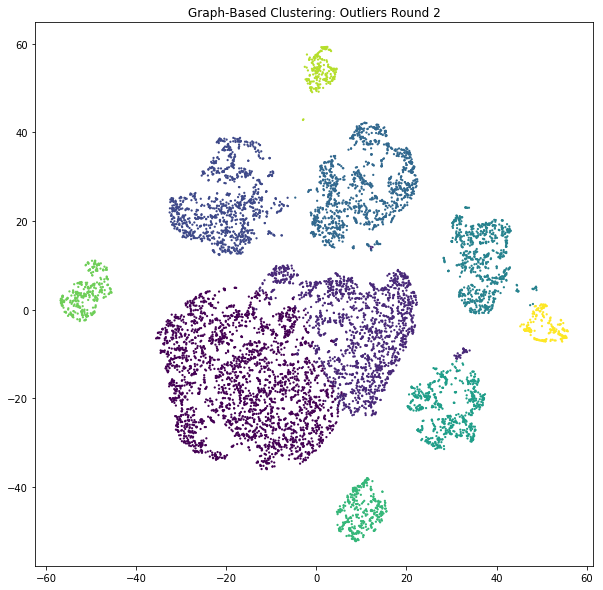

In [4]:
# Round 2 remove outliers
num_clusters=max(clusters['Cluster'])
comx=np.array([])
comy=np.array([])
del_outliers_round2=np.array([])
del_barcodes_round2=np.array([])
for x in range(0,num_clusters):
    
    curr_clust=np.where(clusters['Cluster']==x+1)[0]
    # scale to min and max
    xmin=np.min(tsne['TSNE-1'].iloc[curr_clust])
    xmax=np.max(tsne['TSNE-1'].iloc[curr_clust])
    ymin=np.min(tsne['TSNE-2'].iloc[curr_clust])
    ymax=np.max(tsne['TSNE-2'].iloc[curr_clust])

    curr_x=(tsne['TSNE-1'].iloc[curr_clust]-xmin)/(xmax-xmin)
    curr_y=(tsne['TSNE-2'].iloc[curr_clust]-ymin)/(ymax-ymin)
    
    comx=np.append(comx,np.median(curr_x))
    comy=np.append(comy,np.median(curr_y))
    
    dist=np.array([])
    for y in range(0,len(curr_clust)): 
        dist=np.append(dist,spatial.distance.euclidean([comx[x],comy[x]],[curr_x.iloc[y],curr_y.iloc[y]]))
    outliers=np.where(dist>0.5)[0]
    del_outliers_round2=np.append(del_outliers_round2,np.asarray(curr_clust[outliers])).astype(int)
    del_barcodes_round2=np.append(del_barcodes_round2,clusters['Barcode'].iloc[curr_clust[outliers]])
    #plt.scatter(tsne['TSNE-1'].iloc[curr_clust[outliers]],tsne['TSNE-2'].iloc[curr_clust[outliers]],c='k')
#plt.scatter(comx,comy,c='r')
#plt.title('Graph-Based Clustering')

clusters=clusters.drop(clusters.index[del_outliers_round2])
tsne=tsne.drop(tsne.index[del_outliers_round2])

# Plot Round 2 results
plt.figure(figsize=(10, 10))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=clusters['Cluster'], linewidths=0, s=5)
plt.title('Graph-Based Clustering: Outliers Round 2')
#plt.savefig(savefolder+project+'_tsneclust.eps', format='eps', dpi=1000)

del_barcodes=np.append(del_barcodes_round1,del_barcodes_round2)


In [5]:
matrices_dir = "/media/storage/ckk/genomics/data/"+folder+"/counts/"+project+"/"+dataset+"/outs/"
file_matrix_h5 = matrices_dir+"filtered_feature_bc_matrix.h5"

gene_bc_matrix = get_matrix_from_h5(file_matrix_h5)

In [6]:
barcodes_dir = "/media/storage/ckk/genomics/data/"+folder+"/reanalysis/"+project+"/Barcodes/"
barcodes_file=barcodes_dir+dataset+"_QC_barcodes.csv"
indices_file=barcodes_dir+dataset+"_QC_indices.npy"

In [7]:
QCcell_barcodes=np.array([])    
with open(barcodes_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        QCcell_barcodes=np.append(QCcell_barcodes,row[0].encode('UTF-8'))
csv_file.close()
QCcell_barcodes=QCcell_barcodes[1:]

QC_cells=np.array([])
for x in range(0,len(QCcell_barcodes)):
    curr_barcodes=int(np.where(gene_bc_matrix.barcodes==QCcell_barcodes[x])[0])
    QC_cells=np.append(QC_cells,curr_barcodes)
QC_cells=QC_cells.astype(int)

print('Number of cells:',np.shape(QC_cells))

# Delete outlier barcodes
del_outliers=np.array([])
for x in range(0,len(del_barcodes)):
    curr_barcodes=np.where(QCcell_barcodes==del_barcodes[x].encode('UTF-8'))[0]
    del_outliers=np.append(del_outliers,curr_barcodes)
QC_cells=np.delete(QC_cells,del_outliers.astype(int))
QCcell_barcodes=np.delete(QCcell_barcodes,del_outliers.astype(int))

print('Number of QC cells:',np.shape(QC_cells))
print(np.shape(clusters))

Number of cells: (10317,)
Number of QC cells: (9280,)
(9280, 2)


In [8]:
subset_matrix=subsample_matrix(gene_bc_matrix, QC_cells)

# Normalize matrix
subset_matrix_exp = subset_matrix.matrix.toarray().squeeze()
        
# Calculate total and median UMI counts per cell and normalize
total_umicounts_per_cell = np.sum(subset_matrix_exp, axis=0)
median_umicount_across_cells = np.median(total_umicounts_per_cell)
scale_factor = total_umicounts_per_cell/median_umicount_across_cells
subset_matrix_norm = subset_matrix_exp/scale_factor

# No normalization
#subset_matrix_norm = subset_matrix_exp

# Log transform data
#subset_matrix_norm = np.log2(subset_matrix_norm+1)

# Mean-center and scale variance per-gene
#mean_vals=np.nanmean(subset_matrix_norm,axis=1)
#mean_vals=np.reshape(mean_vals,(len(mean_vals),1))
#std_vals=np.nanstd(subset_matrix_norm,axis=1)
#std_vals=np.reshape(std_vals,(len(std_vals),1))
#subset_matrix_norm = (subset_matrix_norm - mean_vals)/std_vals

Text(0.5, 1.0, 'Graph-Based Clustering')

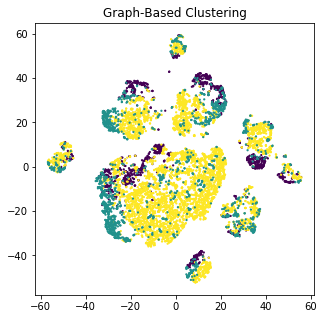

In [9]:
barcodes = subset_matrix.barcodes
def splitGEMs(n): 
    return n[-1]
  
barcodes_last = np.asarray(list(map(splitGEMs, barcodes)))
group1=np.where(barcodes_last==49)[0]
group2=np.where(barcodes_last==50)[0]
group3=np.where(barcodes_last==51)[0]

groups=barcodes_last
groups[groups==49]=-1
groups[groups==50]=1
groups[groups==51]=0

# plot all clusters in TSNE space by group
plt.figure(figsize=(5, 5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=groups, linewidths=0, s=5, vmin=-1, vmax=1)
plt.title('Graph-Based Clustering')
#plt.savefig(savefolder+project+'_groups.eps', format='eps', dpi=1000)

1
Scn4b
2
Calb1
6
Slc17a7
3
Ermn
4
Aqp4
9
Pdgfra
5
Ms4a7
10
Nkg7
7
Abcb1a
8
Tagln


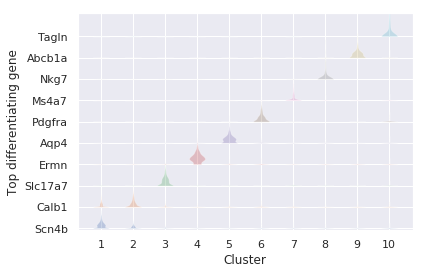

In [69]:
# Identify top most differentiating genes per cluster and plot violinplot
num_clusters=max(clusters['Cluster'])

clust_order = [1,2,6,3,4,9,5,10,7,8] 

# load TSNE and graph clustering
diffexp = pd.read_csv(diffexp_file)

diffgene_list=np.array([])
#for x in range(0,num_clusters):
for x in clust_order:
    diffexp_sort=diffexp.sort_values(by=['Cluster '+str(x)+' Log2 fold change'],ascending=False)
    diffexp_nonzero=diffexp_sort[diffexp_sort['Cluster '+str(x)+' Mean Counts']>1]
    diffexp_sig=diffexp_nonzero[diffexp_nonzero['Cluster '+str(x)+' Adjusted p value']<0.1]
    currgenes=diffexp_sig.iloc[0,1]
    diffgene_list=np.append(diffgene_list,currgenes)
    print(x)
    print(currgenes)

cell_list=np.array([])
#for x in range(0,num_clusters):
for x in clust_order:    
    curr_clust=np.where(clusters['Cluster']==x)[0]
    cell_list=np.append(cell_list,curr_clust).astype(int)   
    
expression_matrix=np.zeros([len(diffgene_list),len(cell_list)])
for x in range(0,len(diffgene_list)):    
    gene_index = np.where(subset_matrix.feature_names == diffgene_list[x])[0]
    currexpr = subset_matrix_norm[gene_index,:]
    currexpr = currexpr[0,cell_list]
    expression_matrix[x,:]=stats.zscore(currexpr)
    
# Plot violin plot
for x in range(0,len(clust_order)):
    curr_clust=np.where(clusters['Cluster']==clust_order[x])[0]
    for y in range(0,len(diffgene_list)): 
        gene_index = np.where(subset_matrix.feature_names == diffgene_list[y])[0]
        currexpr = subset_matrix_norm[gene_index,:]
        currexpr = currexpr[0,curr_clust]
        plt.violinplot(currexpr+y*10,[x],showextrema=False)
        
plt.yticks(np.arange(0,num_clusters*10,step=10),diffgene_list) 
plt.xticks(np.arange(0,num_clusters),np.arange(1,num_clusters+1))
plt.xlabel('Cluster')
plt.ylabel('Top differentiating gene')
plt.ylim(-1,num_clusters*10+1)
        
plt.savefig(savefolder+project+'_violinplots.eps', format='eps', dpi=1000)

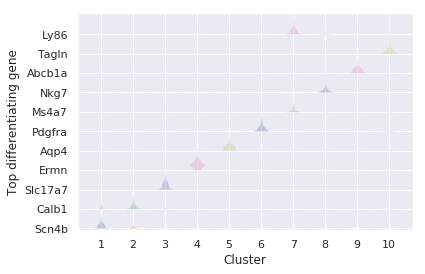

In [30]:
# Plot violinplots using top diff gene for glutamate dataset

num_clusters=max(clusters['Cluster'])

clust_order = [1,2,6,3,4,9,5,10,7,8]  

diffgene_list=['Scn4b','Calb1','Slc17a7','Ermn','Aqp4','Pdgfra','Ms4a7','Nkg7','Abcb1a','Tagln','Ly86']
num_genes=len(diffgene_list)
cell_list=np.array([])
#for x in range(0,num_clusters):
for x in clust_order:    
    curr_clust=np.where(clusters['Cluster']==x)[0]
    cell_list=np.append(cell_list,curr_clust).astype(int)   
    
expression_matrix=np.zeros([len(diffgene_list),len(cell_list)])
for x in range(0,len(diffgene_list)):    
    gene_index = np.where(subset_matrix.feature_names == diffgene_list[x])[0]
    currexpr = subset_matrix_norm[gene_index,:]
    currexpr = currexpr[0,cell_list]
    expression_matrix[x,:]=stats.zscore(currexpr)
    
# Plot violin plot
for x in range(0,len(clust_order)):
    curr_clust=np.where(clusters['Cluster']==clust_order[x])[0]
    for y in range(0,len(diffgene_list)): 
        gene_index = np.where(subset_matrix.feature_names == diffgene_list[y])[0]
        currexpr = subset_matrix_norm[gene_index,:]
        currexpr = currexpr[0,curr_clust]
        plt.violinplot(currexpr+y*10,[x],showextrema=False)
        
plt.yticks(np.arange(0,num_genes*10,step=10),diffgene_list) 
plt.xticks(np.arange(0,num_clusters),np.arange(1,num_clusters+1))
plt.xlabel('Cluster')
plt.ylabel('Top differentiating gene')
plt.ylim(-1,num_genes*10+1)
        
plt.savefig(savefolder+project+'_violinplots_glumatch.eps', format='eps', dpi=1000)

1
9152       Scn4b
12773      Adcy5
10729       Rgs9
10322       Sez6
8168      Cx3cl1
3953     Rap1gap
6597       Pde2a
12525      Pde1b
3183      Ppp3ca
6361       Ptpn5
Name: Feature Name, dtype: object
2
3305             Calb1
13663            Calm2
5132              Tac1
2919            Mllt11
12962             Pcp4
7263             Zwint
5364              Snca
6911              Caly
12811            Gap43
10238    6330403K07Rik
Name: Feature Name, dtype: object
6
6315     Slc17a7
12265      Nptxr
1056       Olfm1
12714        Sst
5314         Npy
2543       Stmn2
9117        Thy1
11143       Sncb
3555     Slc24a2
12014      Basp1
Name: Feature Name, dtype: object
3
1234       Ermn
6202        Mag
2602     Cldn11
1610        Mal
6904     Nkx6-2
10264      Aspa
14405    Opalin
6271       Klk6
3000     Tspan2
2563       Car2
Name: Feature Name, dtype: object
4
13722       Aqp4
8447     Fam107a
7177        Gja1
12361       Mlc1
8156         Mt2
534      Gpr37l1
10661       Gfap
10338

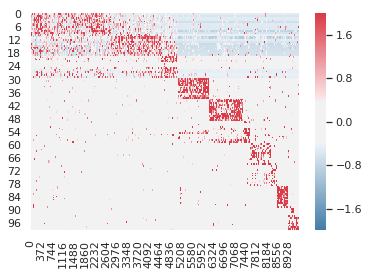

In [11]:
# Identify top 10 most differentiating genes per cluster and plot heatmap
num_clusters=max(clusters['Cluster'])

clust_order = [1,2,6,3,4,9,5,10,7,8] #Thy1L_Aggr 

# load TSNE and graph clustering
diffexp = pd.read_csv(diffexp_file)

diffgene_list=np.array([])
#for x in range(0,num_clusters):
for x in clust_order:
    diffexp_sort=diffexp.sort_values(by=['Cluster '+str(x)+' Log2 fold change'],ascending=False)
    diffexp_nonzero=diffexp_sort[diffexp_sort['Cluster '+str(x)+' Mean Counts']>1]
    diffexp_sig=diffexp_nonzero[diffexp_nonzero['Cluster '+str(x)+' Adjusted p value']<0.1]
    currgenes=diffexp_sig.iloc[0:10,1]
    diffgene_list=np.append(diffgene_list,currgenes)
    print(x)
    print(currgenes)

cell_list=np.array([])
#for x in range(0,num_clusters):
for x in clust_order:    
    curr_clust=np.where(clusters['Cluster']==x)[0]
    cell_list=np.append(cell_list,curr_clust).astype(int)   
    
expression_matrix=np.zeros([len(diffgene_list),len(cell_list)])
for x in range(0,len(diffgene_list)):    
    gene_index = np.where(subset_matrix.feature_names == diffgene_list[x])[0]
    currexpr = subset_matrix_norm[gene_index,:]
    currexpr = currexpr[0,cell_list]
    expression_matrix[x,:]=stats.zscore(currexpr)
    
# Plot heatmap of gene expression
sns.set()
custom_map=sns.diverging_palette(240,10, sep=50, as_cmap=True)

plt.figure
sns.heatmap(expression_matrix, cmap=custom_map, vmin=-2, vmax=2)
#plt.savefig(savefolder+project+'_heatmap.eps', format='eps', dpi=300)

221


Text(0.5, 1.0, 'Graph-Based Clustering')

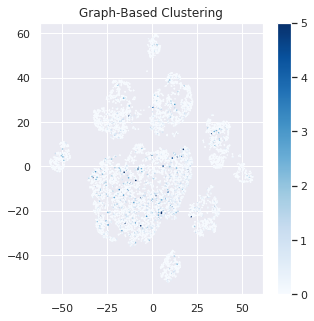

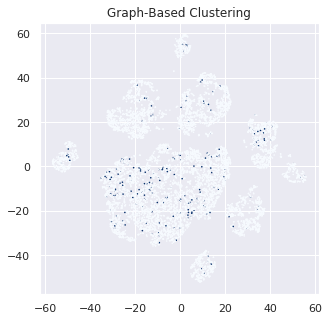

In [12]:
# Plot mCherry gene expression in clusters

mCherry_gene=np.where(subset_matrix.feature_names == 'mCherry')[0]
mCherry_expr=np.asarray(subset_matrix_norm[mCherry_gene, :])[0]
#mCherry_expr=np.log2(mCherry_expr+1)

# plot all clusters in TSNE space by group
plt.figure(figsize=(5, 5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=mCherry_expr, linewidths=0, s=2.5, cmap=plt.cm.Blues,vmin=0,vmax=5)
plt.colorbar()
plt.title('Graph-Based Clustering')
plt.savefig(savefolder+project+'_mCherry.eps', format='eps', dpi=1000)

# threshold mCherry expression
thresh=1.5
mCherry_expr_thresh=mCherry_expr
mCherry_expr_thresh[np.where(mCherry_expr<thresh)[0]]=0
mCherry_cells=np.where(mCherry_expr>=thresh)[0]
print(len(mCherry_cells))

# plot all clusters in TSNE space by group
plt.figure(figsize=(5, 5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=mCherry_expr_thresh, linewidths=0, s=2.5,cmap=plt.cm.Blues,vmin=0,vmax=thresh)
plt.title('Graph-Based Clustering')
#plt.savefig(savefolder+project+'_thresh.eps', format='eps', dpi=1000)




828


Text(0.5, 1.0, 'Graph-Based Clustering')

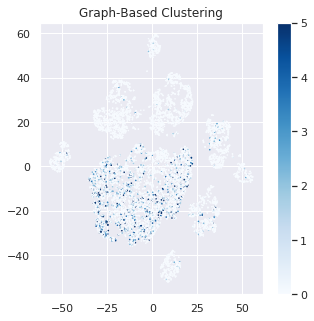

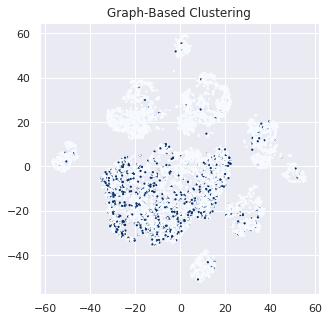

In [13]:
# Plot TEV gene expression in clusters

TEV_gene=np.where(subset_matrix.feature_names == 'TEV')[0]
TEV_expr=np.asarray(subset_matrix_norm[TEV_gene, :])[0]
thresh=1.5
TEV_expr_thresh=TEV_expr
TEV_expr_thresh[np.where(TEV_expr<thresh)[0]]=0
TEV_cells=np.where(TEV_expr>=thresh)[0]
print(len(TEV_cells))

# plot all clusters in TSNE space by group
plt.figure(figsize=(5,5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=TEV_expr, linewidths=0, s=2.5,cmap=plt.cm.Blues, vmin=0, vmax=5)
plt.colorbar()
plt.title('Graph-Based Clustering')
plt.savefig(savefolder+project+'TEV.eps', format='eps', dpi=1000)

# plot all clusters in TSNE space by group
plt.figure(figsize=(5,5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=TEV_expr_thresh, linewidths=0, s=5,cmap=plt.cm.Blues,vmin=0,vmax=thresh)
plt.title('Graph-Based Clustering')

#plt.savefig(savefolder+project+'_thresh.eps', format='eps', dpi=1000)


469


Text(0.5, 1.0, 'Graph-Based Clustering')

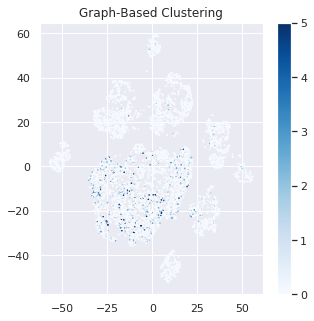

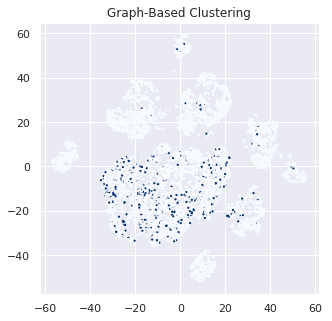

In [14]:
# Plot tTA gene expression in clusters

tTA_gene=np.where(subset_matrix.feature_names == 'tTA')[0]
tTA_expr=np.asarray(subset_matrix_norm[tTA_gene, :])[0]
thresh=1.5
tTA_expr_thresh=tTA_expr
tTA_expr_thresh[np.where(tTA_expr<thresh)[0]]=0
tTA_cells=np.where(tTA_expr>=thresh)[0]
print(len(tTA_cells))

# plot all clusters in TSNE space by group
plt.figure(figsize=(5,5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=tTA_expr, linewidths=0, s=2.5,cmap=plt.cm.Blues, vmin=0,vmax=5)
plt.colorbar()
plt.title('Graph-Based Clustering')
plt.savefig(savefolder+project+'tTA.eps', format='eps', dpi=1000)

# plot all clusters in TSNE space by group
plt.figure(figsize=(5,5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=tTA_expr_thresh, linewidths=0, s=5,cmap=plt.cm.Blues,vmin=0,vmax=thresh)
plt.title('Graph-Based Clustering')

#plt.savefig(savefolder+project+'_thresh.eps', format='eps', dpi=1000)


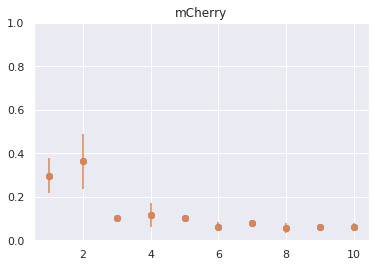

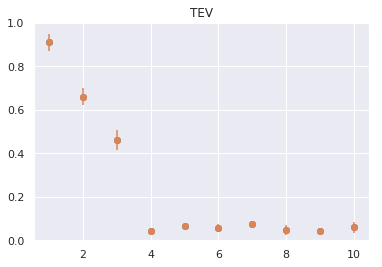

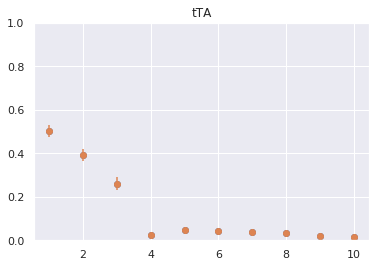

In [16]:
# Plot UMI counts across clusters

mCherry_gene=np.where(subset_matrix.feature_names == 'mCherry')[0]
mCherry_expr_norm=np.asarray(subset_matrix_norm[mCherry_gene, :])[0]

mCherry_clusters_norm_mean=np.zeros(num_clusters)
mCherry_clusters_norm_sem=np.zeros(num_clusters)
mCherry_clusters_norm_dict={}
for x in range(0,num_clusters):
    curr_clust=np.where(clusters['Cluster']==x+1)[0]
    total_clust=len(curr_clust)
    mCherry_clusters_norm_mean[x]=np.mean(mCherry_expr_norm[curr_clust])
    mCherry_clusters_norm_sem[x]=np.std(mCherry_expr_norm[curr_clust])/np.sqrt(total_clust)
    mCherry_clusters_norm_dict['c'+str(x+1)]=mCherry_expr_norm[curr_clust]
mCherry_clusters_norm_mean = [mCherry_clusters_norm_mean[i-1] for i in clust_order]
mCherry_clusters_norm_sem = [mCherry_clusters_norm_sem[i-1] for i in clust_order]

plt.figure
plt.title('mCherry')
plt.plot(np.arange(num_clusters)+1,mCherry_clusters_norm_mean,'o',label='True')
plt.errorbar(np.arange(num_clusters)+1,mCherry_clusters_norm_mean,mCherry_clusters_norm_sem,marker='o',linestyle='none')
plt.ylim([0,1])
plt.savefig(savefolder+project+'_mCherryUMIs_clusters.eps', format='eps', dpi=300)
plt.show()

TEV_gene=np.where(subset_matrix.feature_names == 'TEV')[0]
TEV_expr_norm=np.asarray(subset_matrix_norm[TEV_gene, :])[0]

TEV_clusters_norm_mean=np.zeros(num_clusters)
TEV_clusters_norm_sem=np.zeros(num_clusters)
TEV_clusters_norm_dict={}
for x in range(0,num_clusters):
    curr_clust=np.where(clusters['Cluster']==x+1)[0]
    total_clust=len(curr_clust)
    TEV_clusters_norm_mean[x]=np.mean(TEV_expr_norm[curr_clust])
    TEV_clusters_norm_sem[x]=np.std(TEV_expr_norm[curr_clust])/np.sqrt(total_clust)
    TEV_clusters_norm_dict['c'+str(x+1)]=TEV_expr_norm[curr_clust]
TEV_clusters_norm_mean = [TEV_clusters_norm_mean[i-1] for i in clust_order]
TEV_clusters_norm_sem = [TEV_clusters_norm_sem[i-1] for i in clust_order]
    
plt.figure
plt.title('TEV')
plt.plot(np.arange(num_clusters)+1,TEV_clusters_norm_mean,'o',label='True')
plt.errorbar(np.arange(num_clusters)+1,TEV_clusters_norm_mean,TEV_clusters_norm_sem,marker='o',linestyle='none')
plt.ylim([0,1])
plt.savefig(savefolder+project+'_TEVUMIs_clusters.eps', format='eps', dpi=300)
plt.show()

tTA_gene=np.where(subset_matrix.feature_names == 'tTA')[0]
tTA_expr_norm=np.asarray(subset_matrix_norm[tTA_gene, :])[0]

tTA_clusters_norm_mean=np.zeros(num_clusters)
tTA_clusters_norm_sem=np.zeros(num_clusters)
tTA_clusters_norm_dict={}
for x in range(0,num_clusters):
    curr_clust=np.where(clusters['Cluster']==x+1)[0]
    total_clust=len(curr_clust)
    tTA_clusters_norm_mean[x]=np.mean(tTA_expr_norm[curr_clust])
    tTA_clusters_norm_sem[x]=np.std(tTA_expr_norm[curr_clust])/np.sqrt(total_clust)
    tTA_clusters_norm_dict['c'+str(x+1)]=tTA_expr_norm[curr_clust]
tTA_clusters_norm_mean = [tTA_clusters_norm_mean[i-1] for i in clust_order]
tTA_clusters_norm_sem = [tTA_clusters_norm_sem[i-1] for i in clust_order]
    
plt.figure
plt.title('tTA')
plt.plot(np.arange(num_clusters)+1,tTA_clusters_norm_mean,'o',label='True')
plt.errorbar(np.arange(num_clusters)+1,tTA_clusters_norm_mean,tTA_clusters_norm_sem,marker='o',linestyle='none')
plt.ylim([0,1])
plt.savefig(savefolder+project+'_tTAUMIs_clusters.eps', format='eps', dpi=300)
plt.show()


In [67]:
stats.f_oneway(mCherry_clusters_norm_dict['c2'],mCherry_clusters_norm_dict['c3'])


F_onewayResult(statistic=2.261286189272109, pvalue=0.1327568348611641)

In [ ]:
# Violinplot of FLARE genes

FLAREgene_list=np.array(["TEV","tTA","mCherry"])

for x in range(0,len(clust_order)):
    curr_clust=np.where(clusters['Cluster']==clust_order[x])[0]
    for y in range(0,len(FLAREgene_list)): 
        gene_index = np.where(subset_matrix.feature_names == FLAREgene_list[y])[0]
        currexpr = subset_matrix_norm[gene_index,:]
        currexpr = currexpr[0,curr_clust]
        plt.violinplot(currexpr+y*10,[x],showextrema=False)
        
plt.yticks(np.arange(0,num_clusters*10,step=10),FLAREgene_list) 
plt.xticks(np.arange(0,num_clusters),np.arange(1,num_clusters+1))
plt.xlabel('Cluster')
plt.ylabel('Gene')
plt.ylim(-1,len(FLAREgene_list)*10+1)
        
#plt.savefig(savefolder+project+'_FLARE_violinplots.eps', format='eps', dpi=1000)

In [17]:
# save neuron barcodes

neuron_clusters=np.asarray([1,2,6]) #Thy1L_Aggr

neurons=np.isin(clusters['Cluster'],neuron_clusters)
print(len(np.where(neurons==True)[0]))

neuron_barcodes=QCcell_barcodes[neurons]

analysis_dir = "/media/storage/ckk/genomics/data/"+folder+"/reanalysis/"+project

csvsavefile = analysis_dir+"/Barcodes/"+dataset+'_QC_neurons_barcodes.csv'
with open(csvsavefile, 'w', newline='', encoding='utf8') as f: 
    writer = csv.writer(f)
    writer.writerow(["Barcode"])
    for x in range(0,len(neuron_barcodes)):
        writer.writerow([neuron_barcodes[x].decode('UTF-8')])
        

5134


Number of FLARE+ cells:  1535
Number of FLARE+ neurons:  1406


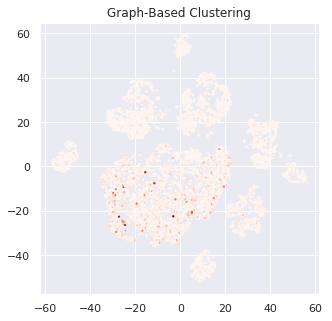

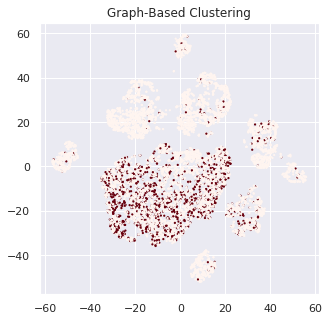

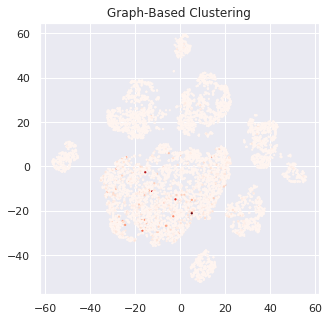

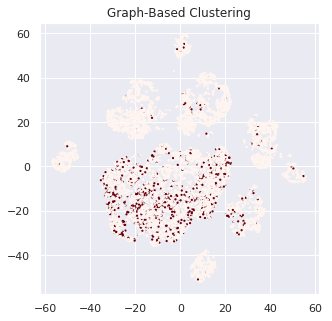

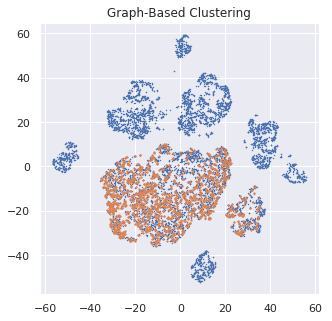

In [18]:
# Define FLARE cells as needing to have EITHER TEVp OR tTA, and save barcodes

gene_list=np.array(["TEV","tTA"])
thresh=1

FLARE_cells=np.array([])
for x in range(0,len(gene_list)):
    gene=np.where(subset_matrix.feature_names == gene_list[x])[0]
    gene_expr=np.asarray(subset_matrix_norm[gene, :])[0]
    
    # plot all clusters in TSNE space by group
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=gene_expr, linewidths=0, s=5,cmap=plt.cm.Reds)
    plt.title('Graph-Based Clustering')
    
    gene_expr_thresh=gene_expr
    gene_expr_thresh[np.where(gene_expr<thresh)[0]]=0
    cells=np.where(gene_expr>=thresh)[0]
        
    # plot all clusters in TSNE space by group
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=gene_expr_thresh, linewidths=0, s=5,cmap=plt.cm.Reds,vmin=0,vmax=thresh)
    plt.title('Graph-Based Clustering')

    FLARE_cells=np.append(FLARE_cells,np.asarray(cells)).astype(int)
    
FLARE_cells=np.unique(FLARE_cells)
FLARE_neurons=FLARE_cells[np.where(np.isin(clusters['Cluster'].iloc[FLARE_cells],neuron_clusters))]

print("Number of FLARE+ cells: ",len(FLARE_cells))
print("Number of FLARE+ neurons: ",len(FLARE_neurons))

plt.figure(figsize=(5, 5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], linewidths=0, s=2,cmap=plt.cm.Reds)
plt.scatter(tsne['TSNE-1'].iloc[FLARE_neurons], tsne['TSNE-2'].iloc[FLARE_neurons], linewidths=0, s=5,cmap=plt.cm.Reds)
plt.title('Graph-Based Clustering')

FLARE_barcodes=QCcell_barcodes[FLARE_neurons]

analysis_dir = "/media/storage/ckk/genomics/data/FLARE2/reanalysis/"+project

csvsavefile = analysis_dir+"/Barcodes/"+dataset+'_QC_neurons_FLARE_barcodes.csv'
with open(csvsavefile, 'w', newline='', encoding='utf8') as f: 
    writer = csv.writer(f)
    writer.writerow(["Barcode"])
    for x in range(0,len(FLARE_barcodes)):
        writer.writerow([FLARE_barcodes[x].decode('UTF-8')])

Number of mCherry+ cells:  421
Number of mCherry+ neurons:  305
Number of mCherry+ FLARE neurons:  182


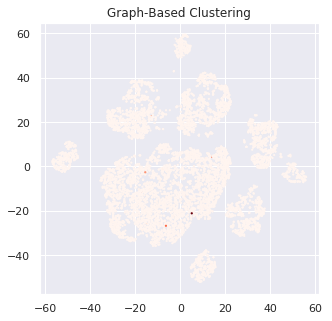

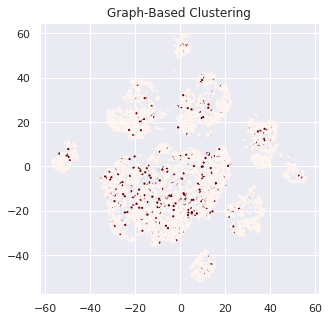

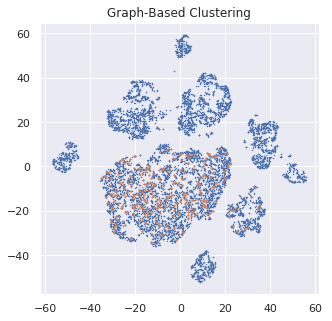

In [19]:
# Save barcodes of mCherry+ neurons

gene_list=np.array(["mCherry"])
thresh=1

mCherry_cells=np.array([])
for x in range(0,len(gene_list)):
    gene=np.where(subset_matrix.feature_names == gene_list[x])[0]
    gene_expr=np.asarray(subset_matrix_norm[gene, :])[0]
    
    # plot all clusters in TSNE space by group
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=gene_expr, linewidths=0, s=5,cmap=plt.cm.Reds)
    plt.title('Graph-Based Clustering')
    
    gene_expr_thresh=gene_expr
    gene_expr_thresh[np.where(gene_expr<thresh)[0]]=0
    cells=np.where(gene_expr>=thresh)[0]
        
    # plot all clusters in TSNE space by group
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=gene_expr_thresh, linewidths=0, s=5,cmap=plt.cm.Reds,vmin=0,vmax=thresh)
    plt.title('Graph-Based Clustering')

    mCherry_cells=np.append(mCherry_cells,np.asarray(cells)).astype(int)
    
mCherry_cells=np.unique(mCherry_cells)
mCherry_neurons=mCherry_cells[np.where(np.isin(clusters['Cluster'].iloc[mCherry_cells],neuron_clusters))]
mCherry_FLARE=mCherry_cells[np.where(np.isin(mCherry_cells,FLARE_neurons))]
print("Number of mCherry+ cells: ",len(mCherry_cells))
print("Number of mCherry+ neurons: ",len(mCherry_neurons))
print("Number of mCherry+ FLARE neurons: ",len(mCherry_FLARE))

plt.figure(figsize=(5, 5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], linewidths=0, s=2,cmap=plt.cm.Reds)
plt.scatter(tsne['TSNE-1'].iloc[mCherry_neurons], tsne['TSNE-2'].iloc[mCherry_neurons], linewidths=0, s=5,cmap=plt.cm.Reds)
plt.title('Graph-Based Clustering')

mCherry_barcodes=QCcell_barcodes[mCherry_neurons]

analysis_dir = "/media/storage/ckk/genomics/data/FLARE2/reanalysis/"+project

csvsavefile = analysis_dir+"/Barcodes/"+dataset+'_QC_neurons_mCherry_barcodes.csv'
with open(csvsavefile, 'w', newline='', encoding='utf8') as f: 
    writer = csv.writer(f)
    writer.writerow(["Barcode"])
    for x in range(0,len(mCherry_barcodes)):
        writer.writerow([mCherry_barcodes[x].decode('UTF-8')])

In [20]:
print("Number of neurons:", len(neurons[neurons==True]))
print("Number of FLARE-expressing neurons:", len(FLARE_neurons))
print("Number of mCherry-expressing neurons:", len(mCherry_neurons))
print("Number of mCherry- and FLARE-expressing neurons:", len(mCherry_FLARE))

Number of neurons: 5134
Number of FLARE-expressing neurons: 1406
Number of mCherry-expressing neurons: 305
Number of mCherry- and FLARE-expressing neurons: 182


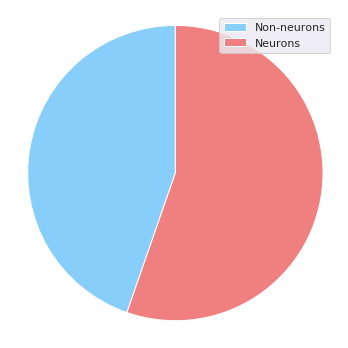

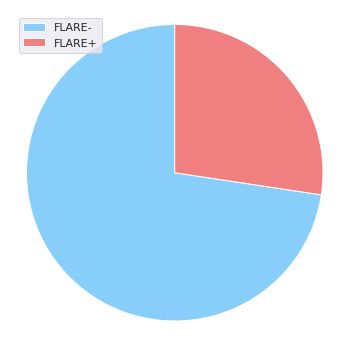

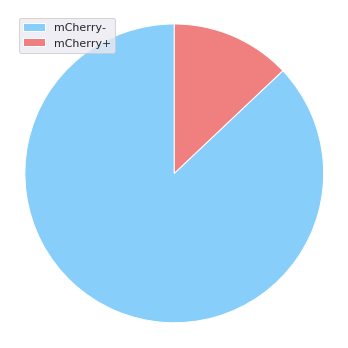

In [21]:
labels = ['Non-neurons', 'Neurons']
sizes = [(9280-5134)/9280,5134/9280]
colors = ['lightskyblue', 'lightcoral']
plt.figure(figsize=(5, 5))
patches, texts = plt.pie(sizes, colors=colors, shadow=False, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
#plt.savefig(savefolder+project+'_neuronpie.eps', format='eps', dpi=1000)

labels = ['FLARE-', 'FLARE+']
sizes = [(5134-1406)/5134,1406/5134]
colors = ['lightskyblue', 'lightcoral']
plt.figure(figsize=(5, 5))
patches, texts = plt.pie(sizes, colors=colors, shadow=False, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
#plt.savefig(savefolder+project+'FLAREpie.eps', format='eps', dpi=1000)

labels = ['mCherry-', 'mCherry+']
sizes = [(1406-182)/1406,182/1406]
plt.figure(figsize=(5, 5))
colors = ['lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=False, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
#plt.savefig(savefolder+project+'mCherrypie.eps', format='eps', dpi=1000)

In [22]:
# Perform bootstrapping to find significantly up- or down-regulated genes in mCherry+ neurons

mCherryFLARE_expr_norm=subset_matrix_norm[:, mCherry_FLARE]
mCherryFLARE_expr_norm_mean=np.mean(mCherryFLARE_expr_norm,axis=1)

num_shuffles=10000
num_genes=len(mCherryFLARE_expr_norm[:,0])
num_mCherryFLARE=len(mCherry_FLARE)
num_FLARE=len(FLARE_neurons)

randFLARE_expr_norm=np.empty([num_genes,num_shuffles])
for x in range(0,num_shuffles):
    FLARE_rand = list(np.sort(np.random.choice(num_FLARE,num_mCherryFLARE,replace=False)))
    temp = np.asarray(subset_matrix_norm[:, FLARE_neurons[FLARE_rand]])
    randFLARE_expr_norm[:,x]=np.mean(temp,axis=1)

In [23]:
# Calculate p-values for shuffling 

pval=np.empty([num_genes,1])
pvalneg=np.empty([num_genes,1])
for x in range(0,num_genes):
    rand_expr=randFLARE_expr_norm[x,:]
    true_expr=mCherryFLARE_expr_norm_mean[x]
    pval[x]=len(np.where(rand_expr>=true_expr)[0])/num_shuffles
    pvalneg[x]=len(np.where(rand_expr<=true_expr)[0])/num_shuffles

sigpos_genes=np.where(pval<0.05)[0]
signeg_genes=np.where(pvalneg<0.05)[0]
sig_genes=np.array([])
sig_genes=np.append(sig_genes,sigpos_genes)
sig_genes=np.append(sig_genes,signeg_genes)
sig_genes=sig_genes.astype(int)

print("Number of significant genes:", len(sig_genes))
print("Number of significant pos genes:", len(sigpos_genes))
print("Number of significant neg genes:", len(signeg_genes))

Number of significant genes: 1297
Number of significant pos genes: 666
Number of significant neg genes: 631


In [24]:
gene_names=subset_matrix.feature_names

savefile=savefolder+project+"_mCherryFLARE.npy"
np.save(savefile,mCherryFLARE_expr_norm)
savefile=savefolder+project+"_mCherryFLAREgenes.npy"
np.save(savefile,gene_names)

In [25]:
sig_expr_mean=mCherryFLARE_expr_norm_mean[sig_genes]
sig_rand_expr_mean=np.mean(randFLARE_expr_norm[sig_genes,:],axis=1)
sig_expr=mCherryFLARE_expr_norm[sig_genes,:]
sig_names=subset_matrix.feature_names[(sig_genes),]

# delete any genes that are from the original excluded gene list
excludegenes_file = barcodes_dir+project+"_QC_excludegenes_names.csv"
excludegenes = pd.read_csv(excludegenes_file)
del_sig=np.where(np.isin(sig_names,excludegenes))[0]
sig_expr=np.delete(sig_expr,del_sig,axis=0)
sig_rand_expr_mean=np.delete(sig_rand_expr_mean,del_sig)
sig_expr_mean=np.delete(sig_expr_mean,del_sig)
sig_names=np.delete(sig_names,del_sig)
sig_genes=np.delete(sig_genes,del_sig)

# delete FLARE genes
FLAREgenes=['mCherry','TEV','tTA']
del_FLARE=np.where(np.isin(sig_names,FLAREgenes))[0]
sig_expr=np.delete(sig_expr,del_FLARE,axis=0)
sig_rand_expr_mean=np.delete(sig_rand_expr_mean,del_FLARE)
sig_expr_mean=np.delete(sig_expr_mean,del_FLARE)
sig_names=np.delete(sig_names,del_FLARE)
sig_genes=np.delete(sig_genes,del_FLARE)

print(np.shape(sig_rand_expr_mean))
print(np.shape(sig_expr_mean))

sig_fold=(sig_expr_mean)-(sig_rand_expr_mean)
order=np.argsort(sig_fold)
sig_fold_sort=sig_fold[order]
sig_names_sort=sig_names[order]
sig_genes_sort=sig_genes[order]

print("Up-regulated genes",sig_names_sort[-40:])
print("Up-regulated genes",sig_fold_sort[-40:])
print("Down-regulated genes",sig_names_sort[0:40])
print("Down-regulated genes",sig_fold_sort[0:40])

(1270,)
(1270,)
Up-regulated genes ['Hist1h2bc' 'Tecr' 'Ap1s2' 'Grina' 'Tomm20' 'Rps18' 'Tmed2' 'Tspan7'
 'Rgs9' 'Ndufs7' 'Pfdn2' 'Ubc' 'Itm2b' 'Arpc2' 'Tma7' 'Dynlrb1' 'Emc6'
 'Atp6v1d' 'Scamp1' 'Tomm70a' 'Phactr1' 'Uqcrq' 'Zfand5' 'Calb1' 'Lrpap1'
 'Dnaja1' 'B2m' 'Gad1' 'Chchd2' 'Hspa5' 'Pdyn' 'H3f3b' 'Syt4' 'Eif1'
 'Zwint' 'Scg2' 'Sub1' 'Ftl1' 'Ubb' 'Tac1']
Up-regulated genes [0.12774072 0.12793736 0.13009858 0.13129887 0.1446328  0.14674711
 0.14928129 0.15065662 0.15307204 0.15528881 0.15722981 0.15867238
 0.15920535 0.16081956 0.16129282 0.16331308 0.1660422  0.16837706
 0.1690189  0.17374702 0.18098848 0.18136921 0.1828305  0.18667755
 0.197608   0.2116264  0.2147997  0.22467058 0.2250155  0.22848635
 0.24519636 0.25632277 0.2577076  0.27878128 0.28440138 0.39722557
 0.456996   0.46814131 0.91615262 1.20025168]
Down-regulated genes ['Penk' 'Syt1' 'Snap25' 'Actb' 'Camk2n1' 'Aldoa' 'Camk2b' 'Calm3' 'Eef1a1'
 'Gnas' 'Cox7c' 'Itm2c' 'Ppp3r1' 'Rps29' 'Cadm2' 'Tuba1b' 'Mef2c' 'Hpca'
 

[1253]
[1197]
[1269]


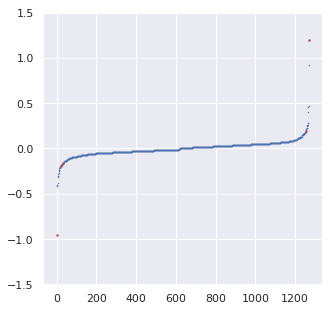

In [48]:
plt.figure(figsize=(5, 5))
xaxis=np.arange(0,len(sig_names))
plt.scatter(xaxis, (sig_fold_sort), linewidths=0, s=2)
plt.ylim([-1.5, 1.5])


Tac1_ind=np.where(sig_names_sort=='Tac1')[0]
Oprk1_ind=np.where(sig_names_sort=='Oprk1')[0]
Calb1_ind=np.where(sig_names_sort=='Calb1')[0]
Penk_ind=np.where(sig_names_sort=='Penk')[0]
Adora2a_ind=np.where(sig_names_sort=='Adora2a')[0]
Tshz1_ind=np.where(sig_names_sort=='Tshz1')[0]
print(Calb1_ind)
print(Oprk1_ind)
print(Tac1_ind)

plt.scatter(xaxis[Tac1_ind],sig_fold_sort[Tac1_ind],s=2,color='r')
plt.scatter(xaxis[Calb1_ind],sig_fold_sort[Calb1_ind],s=2,color='r')
plt.scatter(xaxis[Penk_ind],sig_fold_sort[Penk_ind],s=2,color='r')
plt.scatter(xaxis[Adora2a_ind],sig_fold_sort[Adora2a_ind],s=2,color='r')
plt.scatter(xaxis[Tshz1_ind],sig_fold_sort[Tshz1_ind],s=2,color='r')

plt.savefig(savefolder+project+'_mCherry_upreggenes.eps', format='eps', dpi=1000)

In [85]:
Ptn_ind=np.where(subset_matrix.feature_names == 'Ptn')[0]
Ptn_expr=np.asarray(mCherryFLARE_expr_norm[Ptn_ind,:])[0]
print(np.mean(Ptn_expr))

Calb1_ind=np.where(subset_matrix.feature_names == 'Calb1')[0]
Calb1_expr=np.asarray(mCherryFLARE_expr_norm[Calb1_ind,:])[0]
print(np.mean(Calb1_expr))

Tac1_ind=np.where(subset_matrix.feature_names == 'Tac1')[0]
Tac1_expr=np.asarray(mCherryFLARE_expr_norm[Tac1_ind,:])[0]
print(np.mean(Tac1_expr))



0.7935908759160668
1.234631529473849
4.09291194232717
